1. setting up the environment by importing all necessary libraries

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset  
import torch.utils.data as data_utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import CVAE_EXP as CVAE #python files with the CVAE neural network
import CVAE_function as CVAE_fn



cuda = torch.cuda.is_available()

device = torch.device("mps")



2. defining the functions

In [15]:
def f_y_0(x0, x1):
    return np.cos(49 * x0 + 42 * x1)


def f_y_1(x0, x1):
    return np.cos(4 * x0 + 8 * x1)

functions = [f_y_0, f_y_1]

In [16]:
device

device(type='mps')

In [17]:
data_root = './data_2/'  
filename = "_dataset" 

filename_dataset = f'{data_root}train{filename}.pt'
filename_validation_dataset = f'{data_root}validation{filename}.pt'

dataset = CVAE_fn.SignalDataset(torch.load(filename_dataset))
dataset_validation = CVAE_fn.SignalDataset(torch.load(filename_validation_dataset))

print(f"Train dataset is loaded successfully and has length: {len(dataset)}")
print(f"Validation dataset is loaded successfully and has length: {len(dataset_validation)}")


dataloader = DataLoader(dataset, batch_size = 100, shuffle=True)


validation_loader = DataLoader(dataset_validation, batch_size=100, shuffle=True)

Train dataset is loaded successfully and has length: 100000
Validation dataset is loaded successfully and has length: 3000


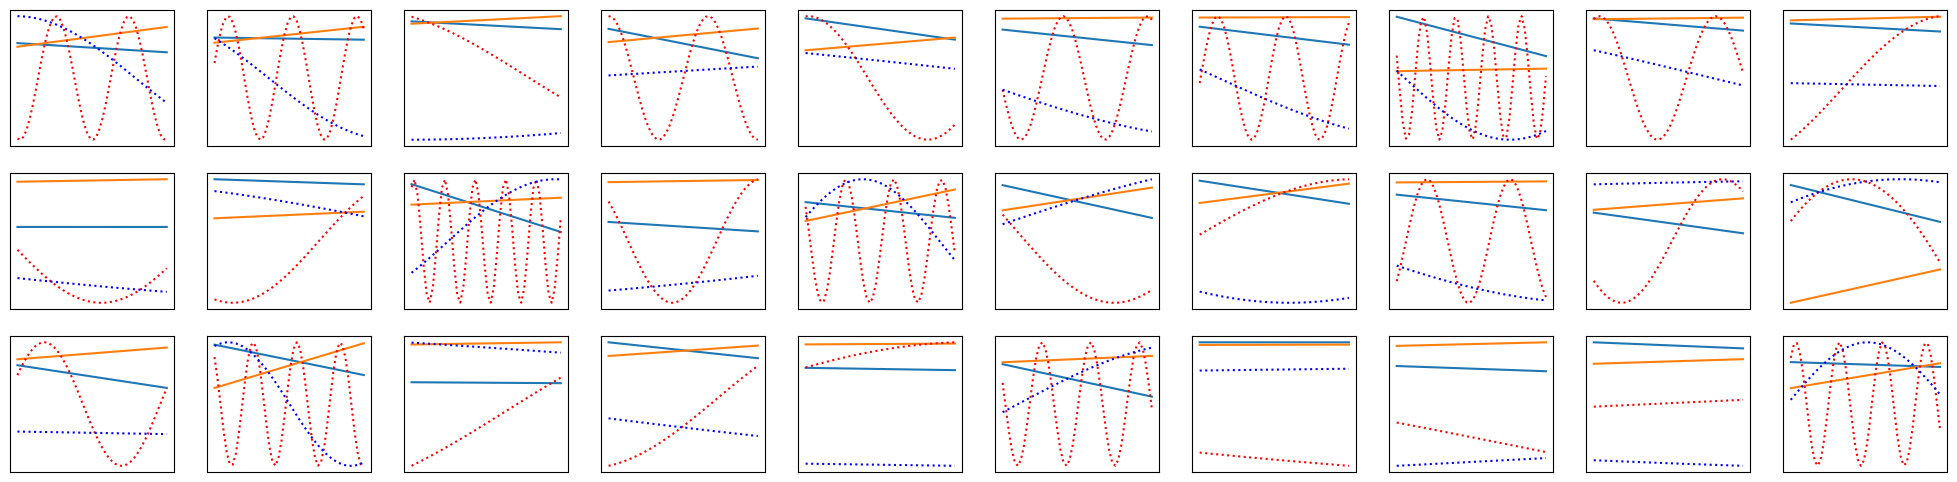

In [18]:
x,y = next(iter(dataloader))        
num_samples = 30

CVAE_fn.plot_samples(x, y, num_samples = num_samples)

In [19]:
number_of_functions = len(functions)

# Customize your Model’s Architecture Based on next dictionary 
model_parameters = {
    "number_of_points": 50,
    "number_of_inputs": 2,
    "number_of_functions": number_of_functions, 
    "bias": True,
    "in_channels1": 1,
    "out_channels1": 32,
    "kernel_size1": [16, 2],
    "out_channels2": 64,
    "kernel_size2": [8, 1]
}

with open('config_model.yaml', 'w') as f:
    yaml.dump(model_parameters, f)
    
    
# Define the input dimensions
number_of_points = 50
number_of_inputs = model_parameters['number_of_inputs']
number_of_functions = model_parameters['number_of_functions']
input_shape = (1, number_of_points, number_of_inputs)
cond_shape = (number_of_points, number_of_functions)


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


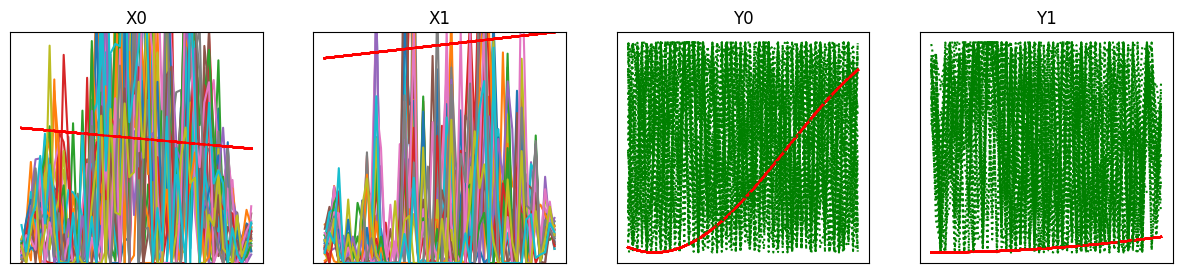

In [20]:
cvae = CVAE.CVAE(latent_dim=100)
model = cvae

dataloader = DataLoader(dataset, batch_size = 250, shuffle=True)
num_samples = 30

x_batch, y_batch = next(iter(dataloader))
y_idx = np.random.randint(250)
given_x = x_batch[y_idx].unsqueeze(0)
given_y = y_batch[y_idx].unsqueeze(0)

given_y = torch.reshape(given_y, (len(given_y), number_of_points* number_of_functions))

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)


In [21]:
hp_param = {
       "batch_size_lowerlimit":250,
       "batch_size_upperlimit":290,
       "wx_lowerlimit":0.1,
       "wx_upperlimit":0.2,
       "wy_lowerlimit":0.1,
       "wy_upperlimit":0.2,
       'LR_LOWER_LIMIT': 0.00005,
       'LR_UPPER_LIMIT': 0.00015,
       'EPOCHS': 40,
       "weight_decay_lowerlimit":0,
       "weight_decay_upperlimit":0.1
       }


In [22]:
import optuna
import torch.optim as optim
beta=1
def objective(hp_param, trial, dataloader, model):
 
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", hp_param["LR_LOWER_LIMIT"], hp_param["LR_UPPER_LIMIT"], log=False)
    wx=trial.suggest_float("wx",hp_param["wx_lowerlimit"],hp_param["wx_upperlimit"])
    wy=trial.suggest_float("wy",hp_param["wy_lowerlimit"],hp_param["wy_upperlimit"])
    batch_size=trial.suggest_int("batch_size",hp_param["batch_size_lowerlimit"],hp_param["batch_size_upperlimit"])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    
    model = CVAE.CVAE() 
    
    
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr,weight_decay=weight_decay)
    
    
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
    random_seed = 0 
    torch.manual_seed(random_seed)
    if cuda:
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

    for epoch in range(1, hp_param["EPOCHS"] + 1):
        epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions)
        
        trial.report(epoch_result["KLD_loss"]+epoch_result["x_loss"]+epoch_result["y_loss"], trial.number) 
    return (beta*epoch_result["KLD_loss"]+wx*epoch_result["x_loss"]+wy*epoch_result["y_loss"])

In [23]:
model = CVAE.CVAE() 
study = optuna.create_study(direction="minimize")
study.optimize(
        lambda trial: objective(hp_param, trial, dataloader,model),
                                n_trials=3)
best_trial = study.best_trial
print(best_trial)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
[I 2024-02-11 00:21:32,961] A new study created in memory with name: no-name-d27528f6-f6a3-4710-913e-121e2fe11649


[W 2024-02-11 00:21:35,982] Trial 0 failed with parameters: {'optimizer': 'RMSprop', 'lr': 6.763156768737269e-05, 'wx': 0.12334905083711506, 'wy': 0.1493725225282727, 'batch_size': 280, 'weight_decay': 0.04843592659551942} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ACER\AppData\Local\Temp\ipykernel_7580\478443789.py", line 4, in <lambda>
    lambda trial: objective(hp_param, trial, dataloader,model),
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ACER\AppData\Local\Temp\ipykernel_7580\162400386.py", line 29, in objective
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
hyperparameters = {
    
    "lr" : best_trial.params["lr"],
    "batch_size" : best_trial.params["batch_size"],
    "beta" : 1,
    "wx": best_trial.params["wx"],
    "wy": best_trial.params["wy"],
    "num_epochs":40,
    "optimizer":best_trial.params["optimizer"],
    "weight_decay":best_trial.params["weight_decay"]
}

lr, batch_size, beta, wx, wy, num_epochs,opt,weight_decay= hyperparameters.values()

if opt=="Adam":
    optimizer = optim.Adam(model.parameters(), lr = lr,weight_decay=weight_decay)
elif opt=="SGD":
    optimizer = optim.SGD(model.parameters(), lr = lr,weight_decay=weight_decay)
elif opt=='RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr = lr,weight_decay=weight_decay)


print(lr, batch_size, beta, wx, wy, num_epochs,opt,weight_decay)

6.777858012347266e-05 247 1 0.2288882003720773 0.18348855328511388 40 Adam 0.09468258837929727


In [ ]:
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions)
    
    
CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions)

Train Epoch 1: Average Loss: 1.547581, KDL: 1.318722, x_loss: 0.349526, y_loss: 0.811255
Train Epoch 2: Average Loss: 0.224421, KDL: 0.011683, x_loss: 0.281382, y_loss: 0.808405
Train Epoch 3: Average Loss: 0.215075, KDL: 0.004360, x_loss: 0.270789, y_loss: 0.810597
Train Epoch 4: Average Loss: 0.212479, KDL: 0.002489, x_loss: 0.257850, y_loss: 0.822782
Train Epoch 5: Average Loss: 0.198575, KDL: 0.001672, x_loss: 0.249160, y_loss: 0.762303
Train Epoch 6: Average Loss: 0.195634, KDL: 0.001198, x_loss: 0.243617, y_loss: 0.755766
Train Epoch 7: Average Loss: 0.194436, KDL: 0.000874, x_loss: 0.238908, y_loss: 0.756877
Train Epoch 8: Average Loss: 0.195158, KDL: 0.000632, x_loss: 0.234752, y_loss: 0.767317
Train Epoch 9: Average Loss: 0.198654, KDL: 0.000470, x_loss: 0.230959, y_loss: 0.791986
Train Epoch 10: Average Loss: 0.203491, KDL: 0.000312, x_loss: 0.227340, y_loss: 0.823721
Train Epoch 11: Average Loss: 0.207189, KDL: 0.000220, x_loss: 0.224060, y_loss: 0.848469
Train Epoch 12: Ave

0.19805111636718115

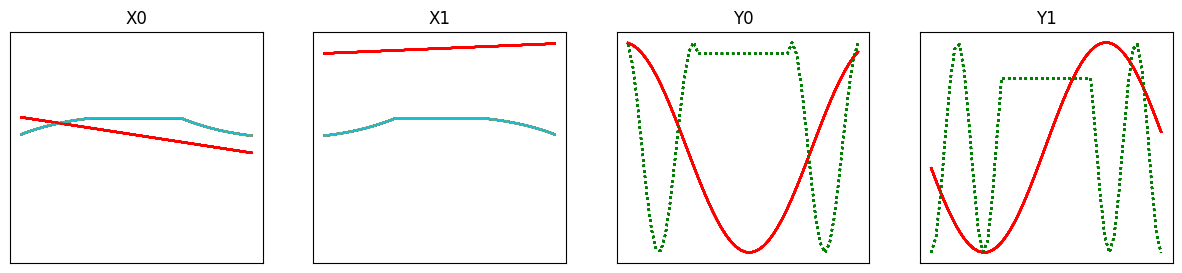

In [ ]:
x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

In [ ]:
filename_scoring_dataset = f'{data_root}scoring{filename}.pt'
scoring_dataset = CVAE_fn.SignalDataset(torch.load(filename_scoring_dataset))

print(f"Scoring dataset is loaded successfully and has length: {len(scoring_dataset)}")

# create a PyTorch DataLoader from the scoring_dataset
scoring_loader = DataLoader(scoring_dataset, batch_size=len(scoring_dataset), shuffle=True)

num_samples = 30
x_batch, y_batch = next(iter(scoring_loader))
x_out= []
y_out = []
for idx in range(len(y_batch)):
    given_y = y_batch[idx].unsqueeze(0)
    given_y = torch.reshape(given_y, (len(given_y), number_of_points * number_of_functions))
    x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
    
    x_out.append(x_output)
    y_out.append(y_output)
    

x_outputs = torch.cat(x_out, dim=0)   
y_outputs = torch.cat(y_out, dim=0) 
x_outputs = x_outputs.cpu()
y_outputs = y_outputs.cpu()



ds = data_utils.TensorDataset(x_outputs,y_outputs)
torch.save(ds, 'result/result_dataset.pt') 



Scoring dataset is loaded successfully and has length: 50


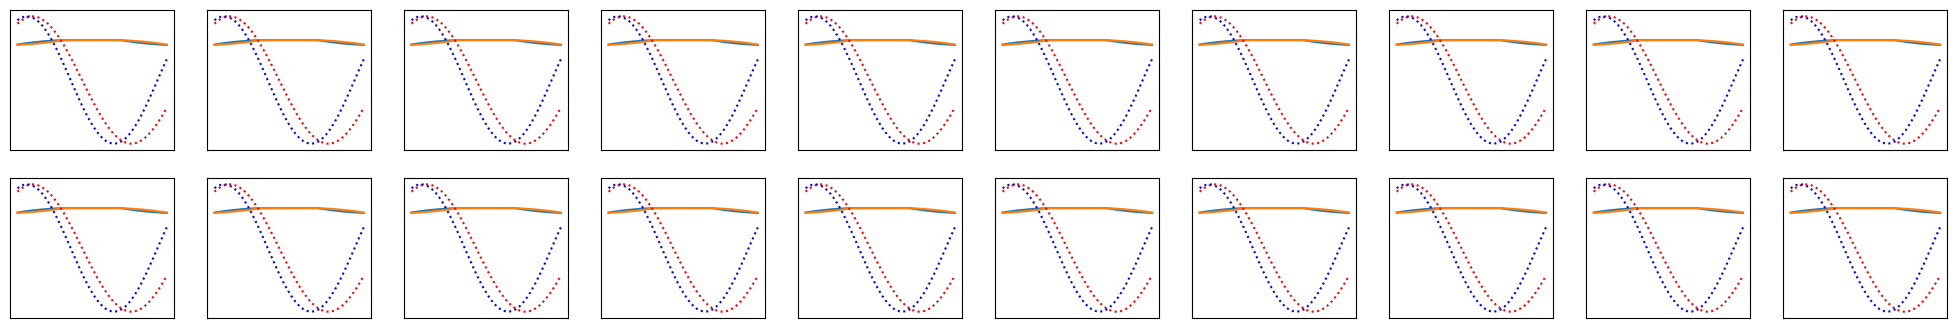

In [ ]:
x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))
      
num_samples = 20

CVAE_fn.plot_samples(x_output, y_output, num_samples = num_samples)

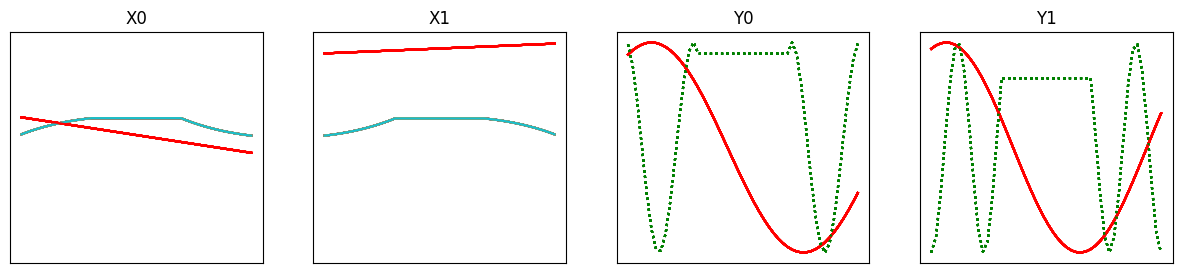

In [ ]:
x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)